# Cargar la base

2024-04-01 10:25:33.636978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 10:25:33.637097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 10:25:33.765265: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


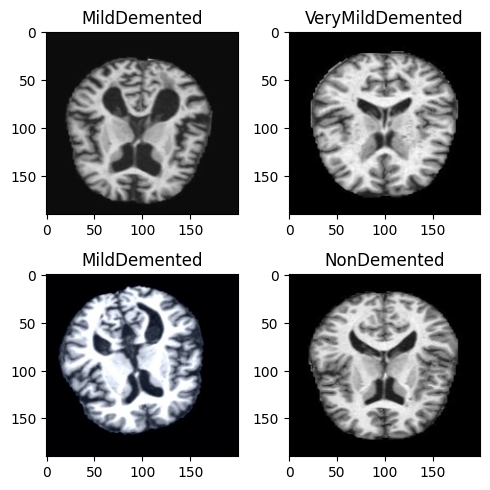

In [2]:
import numpy as np 
import pandas as pd  
import os
import torch
import torchvision
import torch.nn as nn 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
import torchvision.transforms.v2 as v2 
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset 
from torchvision.datasets import ImageFolder
import torch.optim as optim 
from PIL import Image
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F



from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import Counter
from typing import Optional

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns

#dir_path = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset'
dir_path = '/kaggle/input/augmented-alzheimer-mri-dataset-v2/data'
#test_ds = os.path.join(dir_path, 'test')
test_ds = os.path.join(dir_path, 'val')
train_ds = os.path.join(dir_path, 'train')
train = ImageFolder(train_ds)
test = ImageFolder(test_ds)

class_map = {0:'Mild Demented', 1:'Moderate Demented', 2:'Non Demented', 3:'Very Mild Demented'}
class_dict = dict(Counter(train.targets))
class_dict
{0: 717, 1: 52, 2: 2560, 3: 1792}

# Lo que va despues creo que no nos sirve para nada

image_paths = []
for path in train.imgs:
    image_paths.append(path[0])
shuffled = image_paths.copy()    
random.shuffle(shuffled)
plt.figure(figsize=(5,5))

for i, path in enumerate(shuffled):
    if i>3: break
    plt.subplot(2,2,i+1)
    img = Image.open(path)
    image_class = Path(path).parent.stem
    plt.title(image_class)
    plt.imshow(img)
plt.tight_layout()



# Convertir las imagenes a matrices numpy

In [3]:
train_images = []
train_labels = []

for i in range(len(train)):
    train_images.append(np.array(train[i][0]))
    train_labels.append(train[i][1])

In [4]:
test_images = []
test_labels = []

for i in range(len(test)):
    test_images.append(np.array(test[i][0]))
    test_labels.append(test[i][1])

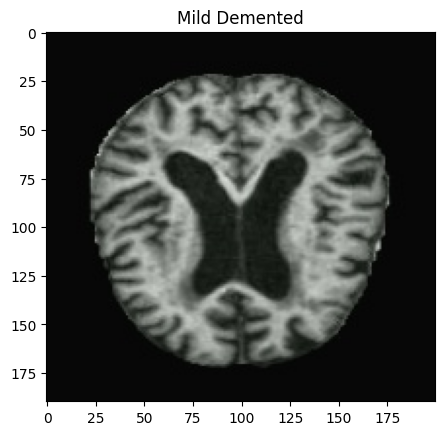

In [5]:
i = 0
plt.imshow(train_images[i])
plt.title(class_map[train_labels[i]])
plt.show()

# Pesos de clase - Desbalanceado

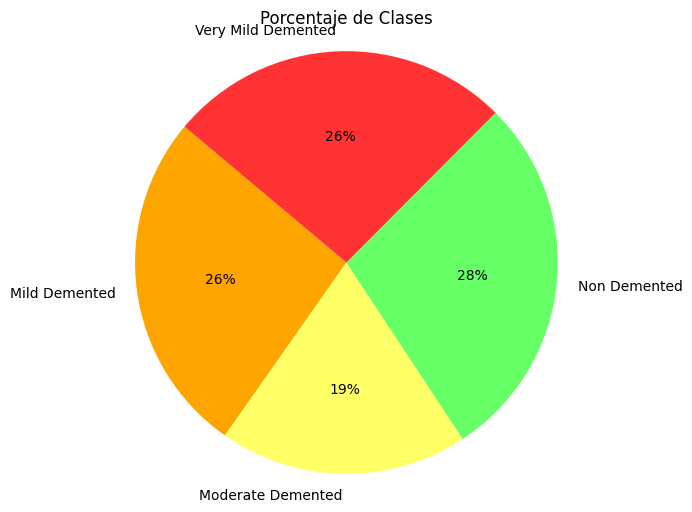

In [6]:
# Calcular el porcentaje de cada clase
total_samples = len(train_labels)
class_percentages = [count / total_samples * 100 for count in class_dict.values()]

# Definir los colores para cada clase
colors = {
    'Mild Demented': '#FFA500',    # Naranja
    'Moderate Demented': '#FFFF66', # Amarillo
    'Non Demented': '#66FF66',      # Verde
    'Very Mild Demented': '#FF3333' # Rojo
}

# Crear una lista de colores ordenada según el orden de las clases en class_map
class_colors = [colors[class_name] for class_name in class_map.values()]

# Crear el gráfico de tartas con los colores personalizados
plt.figure(figsize=(6, 6))
plt.pie(class_percentages, labels=class_map.values(), autopct='%1.0f%%', startangle=140, colors=class_colors)
plt.title('Porcentaje de Clases')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [7]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)
class_weights_dict = dict(zip(np.unique(train_labels), class_weights))

# Redimensionar imagenes a 224x224

In [8]:
import cv2
import numpy as np

def resize_images(images, new_size=(224, 224)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

# Suponiendo que train_images y test_images son tus conjuntos de imágenes originales
# Llamamos a la función resize_images para redimensionar todas las imágenes
train_images = resize_images(train_images)
test_images = resize_images(test_images)

# Aleatorizar el conjunto de entrenamiento y pasar las etiquetas a one-hot encoding

In [9]:
train_images = np.concatenate((train_images, test_images), axis=0)
train_labels = np.concatenate((train_labels, test_labels), axis=0)

In [10]:
def aleatorio(images, labels):
    ale = list(zip(images, labels))
    np.random.shuffle(ale)
    images, labels = zip(*ale)
    return np.array(images), np.array(labels)

In [11]:
train_images, train_labels = aleatorio(train_images, train_labels)

In [12]:
train_labels = to_categorical(train_labels)

In [13]:
#test_images = train_images[:8077]
#test_labels = train_labels[:8077]
#val_images = train_images[8077:16154]
#val_labels = train_labels[8077:16154]
#train_images = train_images[16154:]
#train_labels = train_labels[16154:]

In [14]:
test_images = train_images[:7500]
test_labels = train_labels[:7500]
train_images = train_images[7500:]
train_labels = train_labels[7500:]

In [15]:
#train_images, train_labels = aleatorio(train_images, train_labels)
#test_images, test_labels = aleatorio(test_images, test_labels)

In [16]:
#train_labels = to_categorical(train_labels)
#test_labels = to_categorical(test_labels)

# Cargar el modelo por transferencia

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Resizing
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

# Suponiendo que tienes tus datos de imágenes cargados en X_train, X_test (208x176x3) y las etiquetas en y_train, y_test

# Define el número de clases
num_classes = 4

# Cargar el modelo ResNet50 pre-entrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Input shape no especificado

# Congelar las capas base para que no se vuelvan a entrenar
base_model.trainable = False

# Agregar capas adicionales para adaptar el modelo a tu problema de clasificación
model = Sequential([
    #Resizing(224, 224),  # Redimensiona las imágenes a 224x224, el tamaño de entrada estándar de ResNet50
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax') # 4 clases de salida
])

# Compilar el modelo especificando la función de pérdida, el optimizador y las métricas
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con tus datos de entrenamiento
#history = model.fit(train_images, train_labels, epochs=15, batch_size=64, validation_data=(val_images, val_labels), class_weight=class_weights_dict)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
def plot_training_curves(history):

    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    epochs = range(len(history.history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')

    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')

    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();

    return

In [19]:
#plot_training_curves(history)

In [20]:
# Entrenar el modelo con tus datos de entrenamiento
model.fit(train_images, train_labels, epochs=5, batch_size=64, class_weight=class_weights_dict)

Epoch 1/5
  1/514 ━━━━━━━━━━━━━━━━━━━━ 3:12:51 23s/step - accuracy: 0.2500 - loss: 2.7832

I0000 00:00:1711967519.741434     115 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


514/514 ━━━━━━━━━━━━━━━━━━━━ 114s 179ms/step - accuracy: 0.5979 - loss: 10.4481
Epoch 2/5
514/514 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9023 - loss: 0.2518
Epoch 3/5
514/514 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9479 - loss: 0.1380
Epoch 4/5
514/514 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9788 - loss: 0.0648
Epoch 5/5
514/514 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.9729 - loss: 0.0738


In [21]:
# Predicciones en conjunto de prueba
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

correct_predictions = np.sum(predicted_labels == np.argmax(test_labels, axis=1))
total_predictions = len(np.argmax(test_labels, axis=1))
accuracy = correct_predictions / total_predictions * 100
print("Accuracy:", round(accuracy,2), "%")

235/235 ━━━━━━━━━━━━━━━━━━━━ 36s 110ms/step
Accuracy: 92.95 %


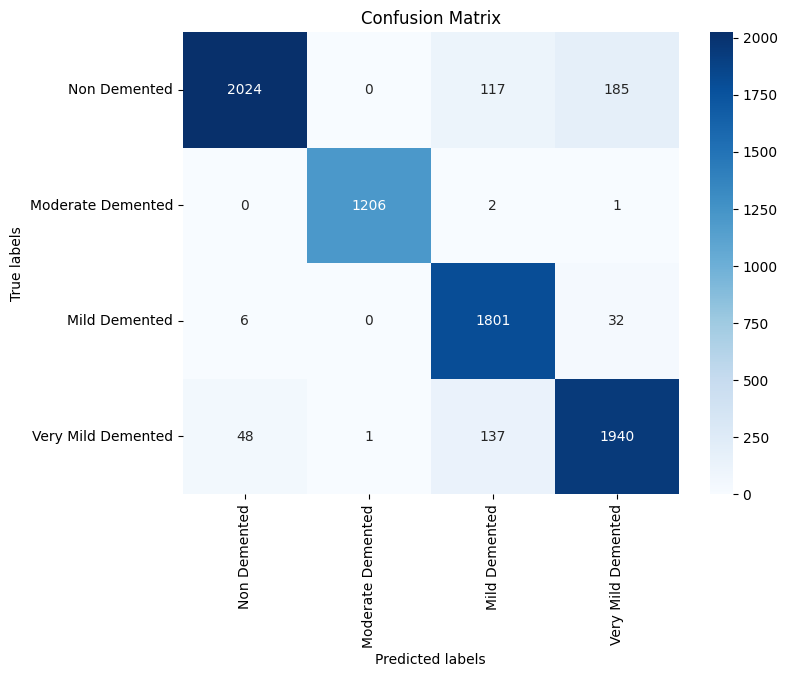

In [22]:
# Nombres de las clases
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Crear matriz de confusión
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

# Reorganizar la matriz de confusión para cambiar el orden de las columnas
new_order = [2, 1, 0, 3]  # Nuevo orden de las columnas: Non Demented, Moderate, Mild, Very Mild
conf_matrix_reordered = conf_matrix[:, new_order][new_order]

# Visualizar matriz de confusión con las columnas en el nuevo orden
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_reordered, annot=True, fmt='d', cmap='Blues', xticklabels=[class_names[i] for i in new_order], yticklabels=[class_names[i] for i in new_order])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

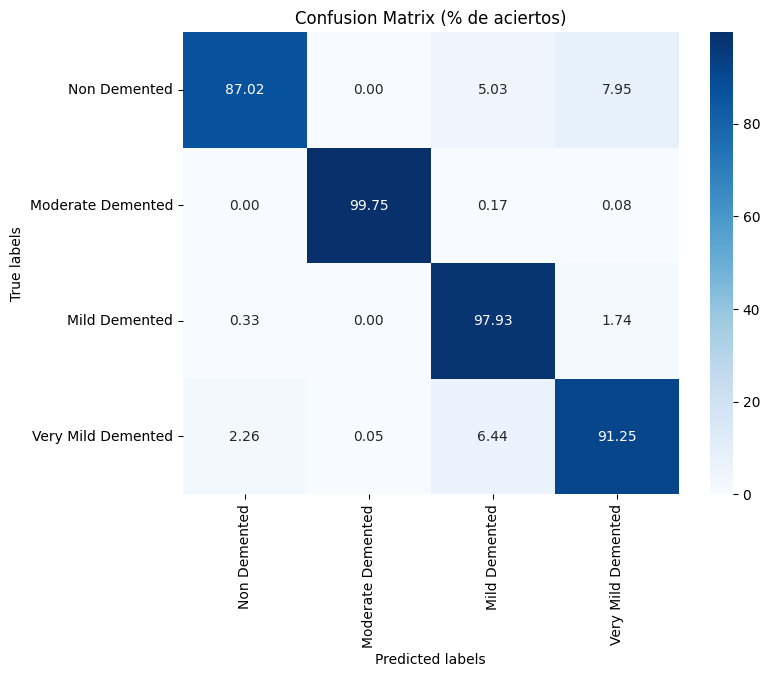

In [23]:
# Nombres de las clases
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Crear matriz de confusión
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

# Reorganizar la matriz de confusión para cambiar el orden de las columnas
new_order = [2, 1, 0, 3]  # Nuevo orden de las columnas: Non Demented, Moderate, Mild, Very Mild
conf_matrix_reordered = conf_matrix[:, new_order][new_order]

# Calcular porcentaje de aciertos por clase
total_per_class = np.sum(conf_matrix_reordered, axis=1)
conf_matrix_percentage = (conf_matrix_reordered.T / total_per_class).T * 100

# Visualizar matriz de confusión con los porcentajes en lugar de los números
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=[class_names[i] for i in new_order], yticklabels=[class_names[i] for i in new_order])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (% de aciertos)')
plt.show()

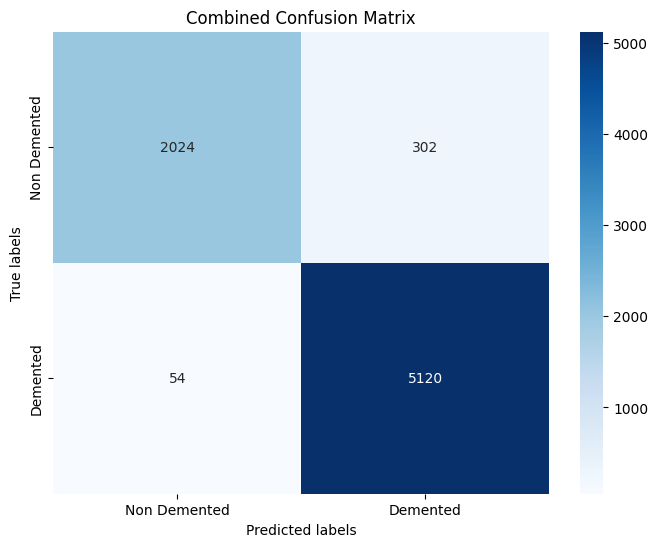

In [24]:
# Nombres de las clases
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Crear matriz de confusión
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

# Reorganizar la matriz de confusión para cambiar el orden de las columnas
new_order = [2, 1, 0, 3]  # Nuevo orden de las columnas: Non Demented, Moderate, Mild, Very Mild
conf_matrix_reordered = conf_matrix[:, new_order][new_order]

# Sumar las últimas tres filas y columnas
conf_matrix_combined = np.zeros((2, 2), dtype=int)
conf_matrix_combined[0, 0] = conf_matrix_reordered[0, 0]  # Mantiene la primera celda igual
conf_matrix_combined[0, 1] = conf_matrix_reordered[0, 1:].sum()    # Suma la segunda y tercera columna
conf_matrix_combined[1, 0] = conf_matrix_reordered[1:, 0].sum()    # Suma la segunda y tercera fila
conf_matrix_combined[1, 1] = conf_matrix_reordered[1:, 1:].sum()     # Suma las últimas dos filas y columnas

# Visualizar matriz de confusión con las últimas tres filas y columnas combinadas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_combined, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Demented', 'Demented'], yticklabels=['Non Demented', 'Demented'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Combined Confusion Matrix')
plt.show()

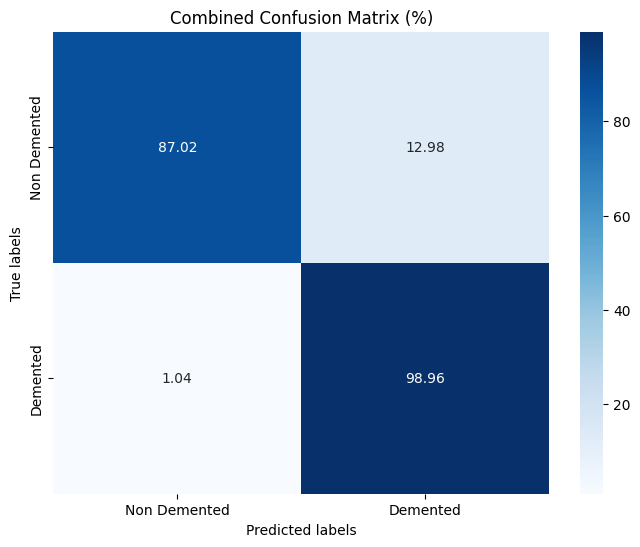

In [25]:
# Nombres de las clases
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

# Crear matriz de confusión
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted_labels)

# Reorganizar la matriz de confusión para cambiar el orden de las columnas
new_order = [2, 1, 0, 3]  # Nuevo orden de las columnas: Non Demented, Moderate, Mild, Very Mild
conf_matrix_reordered = conf_matrix[:, new_order][new_order]

# Sumar las últimas tres filas y columnas
conf_matrix_combined = np.zeros((2, 2), dtype=int)
conf_matrix_combined[0, 0] = conf_matrix_reordered[0, 0]  # Mantiene la primera celda igual
conf_matrix_combined[0, 1] = conf_matrix_reordered[0, 1:].sum()    # Suma la segunda y tercera columna
conf_matrix_combined[1, 0] = conf_matrix_reordered[1:, 0].sum()    # Suma la segunda y tercera fila
conf_matrix_combined[1, 1] = conf_matrix_reordered[1:, 1:].sum()     # Suma las últimas dos filas y columnas

# Calcular el total de muestras para cada clase
total_samples_per_class_combined = np.sum(conf_matrix_combined, axis=1)

# Calcular porcentaje
conf_matrix_percent_combined = conf_matrix_combined.astype('float') / total_samples_per_class_combined[:, np.newaxis] * 100

# Visualizar matriz de confusión combinada con los porcentajes
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_combined, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Non Demented', 'Demented'], yticklabels=['Non Demented', 'Demented'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Combined Confusion Matrix (%)')
plt.show()

In [26]:
def plot_image(i, predictions_array, true_label, img, clases_animales):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == np.argmax(true_label):
        color = 'blue'
    else:
        color = 'red'

    predicted_class = clases_animales[predicted_label]
    true_class = clases_animales[np.argmax(true_label)]

    plt.xlabel("Predicción: {} \n Probabilidad: {:2.0f}% \n Real: {}".format(predicted_class,
                                          100 * np.max(predictions_array),
                                          true_class),
               color=color)


def plot_value_array(i, predictions_array, true_label, clases_animales):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.yticks([])

    thisplot = plt.bar(range(len(predictions_array)), predictions_array, color="#00FF00")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    predicted_class = clases_animales[predicted_label]
    true_class = clases_animales[np.argmax(true_label)]

    thisplot[predicted_label].set_color('red')
    thisplot[np.argmax(true_label)].set_color('black')

In [27]:
classes = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

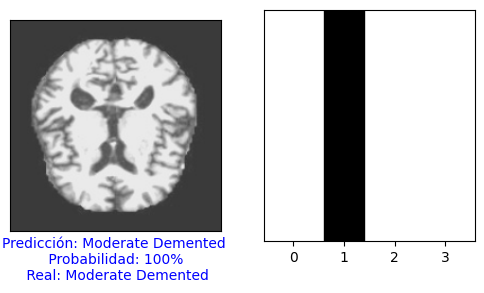

<Figure size 640x480 with 0 Axes>

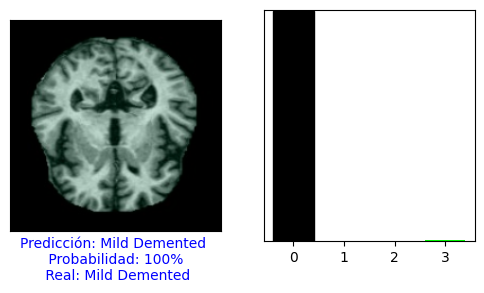

<Figure size 640x480 with 0 Axes>

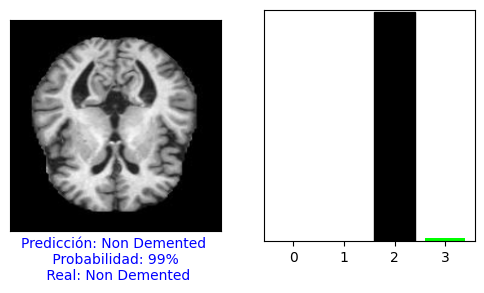

<Figure size 640x480 with 0 Axes>

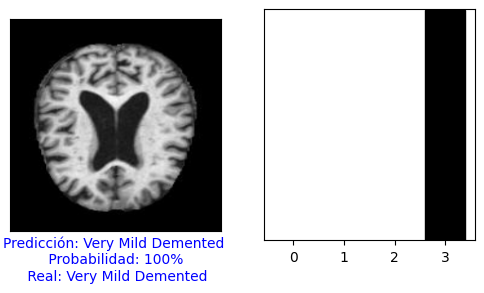

<Figure size 640x480 with 0 Axes>

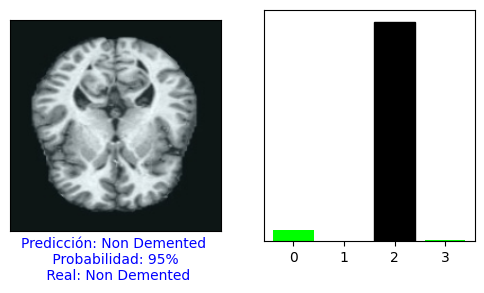

<Figure size 640x480 with 0 Axes>

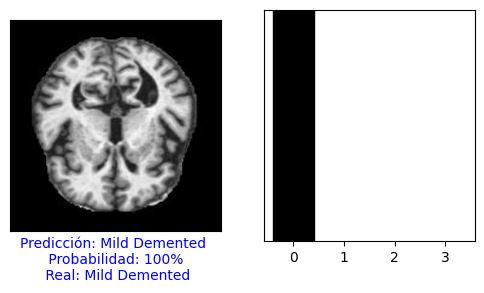

<Figure size 640x480 with 0 Axes>

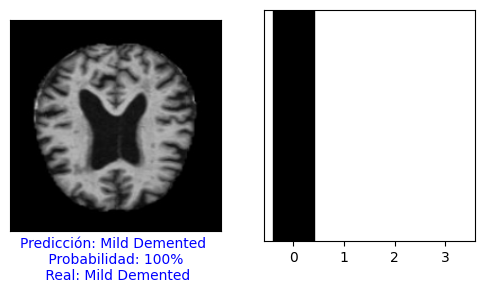

<Figure size 640x480 with 0 Axes>

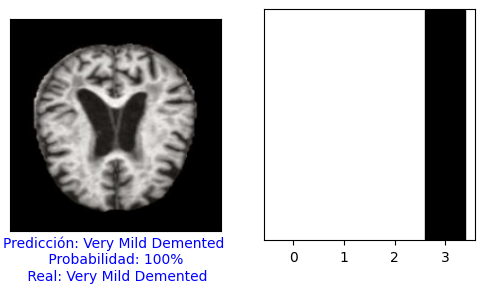

<Figure size 640x480 with 0 Axes>

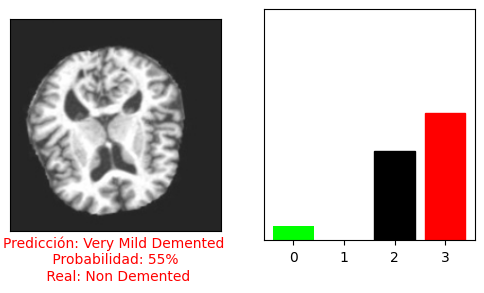

<Figure size 640x480 with 0 Axes>

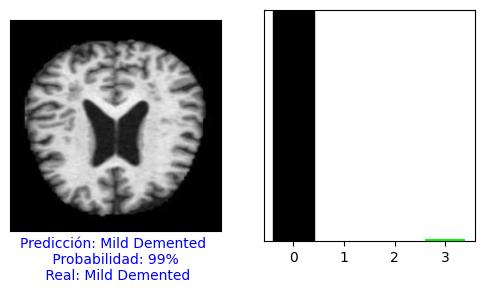

<Figure size 640x480 with 0 Axes>

In [28]:
for j in range(10):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(j, predictions[j], test_labels, test_images, classes)
  plt.subplot(1,2,2)
  plot_value_array(j, predictions[j],  test_labels, classes)
  plt.show()
  plt.clf()

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def visualizar_gradientes(model, imagen_ejemplo, predicciones):
    # Diccionario para mapear las clases numéricas a sus nombres correspondientes
    clases = {
        0: 'Mild Demented',
        1: 'Moderate Demented',
        2: 'Non Demented',
        3: 'Very Mild Demented'
    }
    
    # Obtener la clase predicha para la imagen de ejemplo
    clase_predicha = np.argmax(predicciones)

    # Calcular los gradientes con respecto a la clase predicha
    with tf.GradientTape() as tape:
        entrada = tf.cast(np.expand_dims(imagen_ejemplo, axis=0), tf.float32)
        tape.watch(entrada)
        predicciones = model(entrada)
        clase_objetivo = predicciones[:, clase_predicha]

    gradientes = tape.gradient(clase_objetivo, entrada)

    # Normalizar los gradientes
    gradientes = tf.squeeze(gradientes)
    grad_norm = tf.norm(gradientes)
    gradientes /= grad_norm + 1e-8

    # Calcular la media de los gradientes
    media_grad = tf.reduce_mean(gradientes)

    # Aplicar transformación no lineal para resaltar los valores cercanos a la media
    gradients_transformados = tf.math.log(tf.abs(gradientes - media_grad) + 0.01)  # Usamos logaritmo para amplificar las diferencias cerca de la media

    # Normalizar a un rango de 0 a 1
    gradients_transformados = (gradients_transformados - tf.reduce_min(gradients_transformados)) / (
                tf.reduce_max(gradients_transformados) - tf.reduce_min(gradients_transformados))

    # Asignar colores según el valor del gradiente
    gradientes_coloreados = np.zeros_like(gradients_transformados)
    gradientes_coloreados[gradients_transformados > 0.75] = 0.5  # Verde
    gradientes_coloreados[(gradients_transformados > 0.5) & (gradients_transformados <= 0.75)] = 0.7  # Azul
    gradientes_coloreados[(gradients_transformados > 0.25) & (gradients_transformados <= 0.5)] = 0.3  # Rojo
    
    # Visualizar los gradientes junto con la imagen original
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(imagen_ejemplo)
    axs[0].set_title('Imagen Original')
    axs[0].axis('off')
    
    axs[1].imshow(imagen_ejemplo)
    axs[1].imshow(gradientes_coloreados, cmap='viridis', alpha=0.7)  # Añadir los gradientes con transparencia
    axs[1].set_title('Gradientes con respecto a {}'.format(clases[clase_predicha]))
    axs[1].axis('off')
    
    plt.show()

In [30]:
imagenes_analizar = []
for i in [2,1,0,3]:
    count = 0
    j = 0
    while count < 5:
        if np.argmax(predictions[j]) == np.argmax(test_labels[j]):
            if np.argmax(predictions[j]) == i:
                imagenes_analizar.append(j)
                count += 1
        if count == 3: break
        j += 1

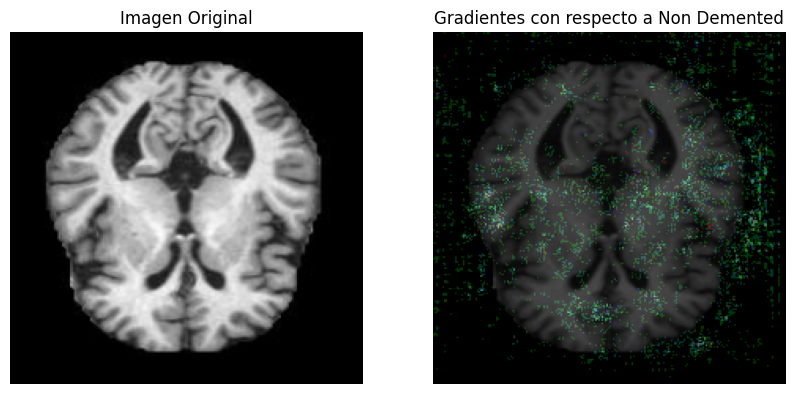

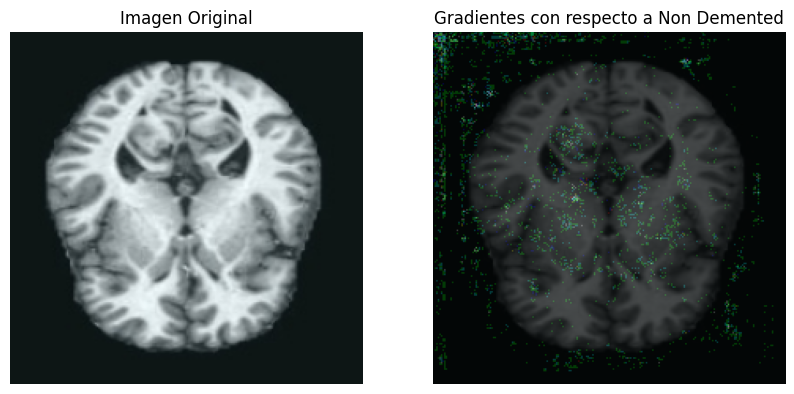

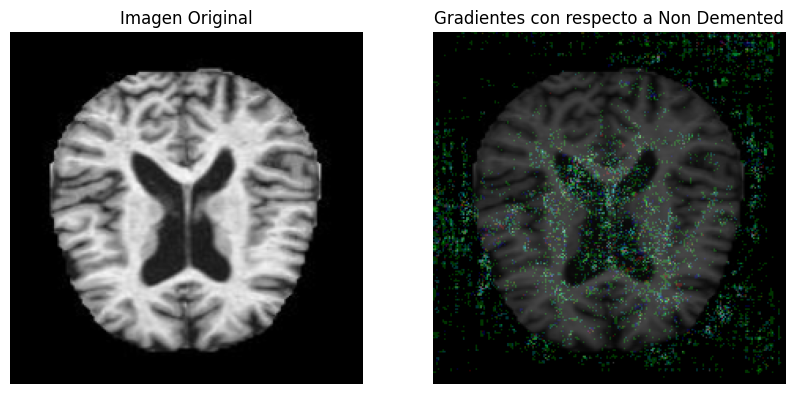

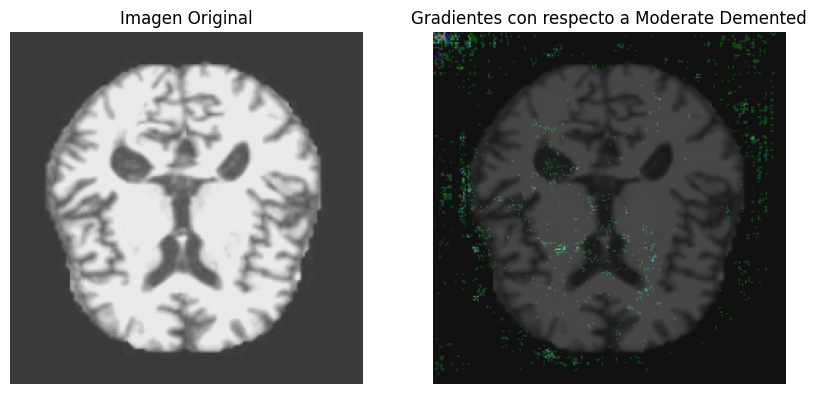

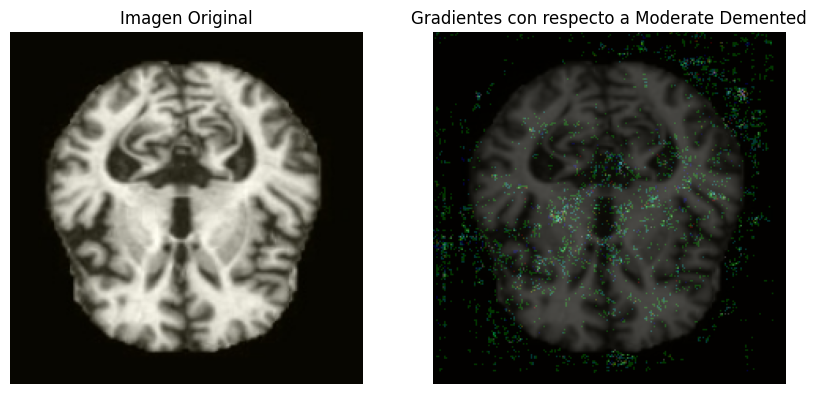

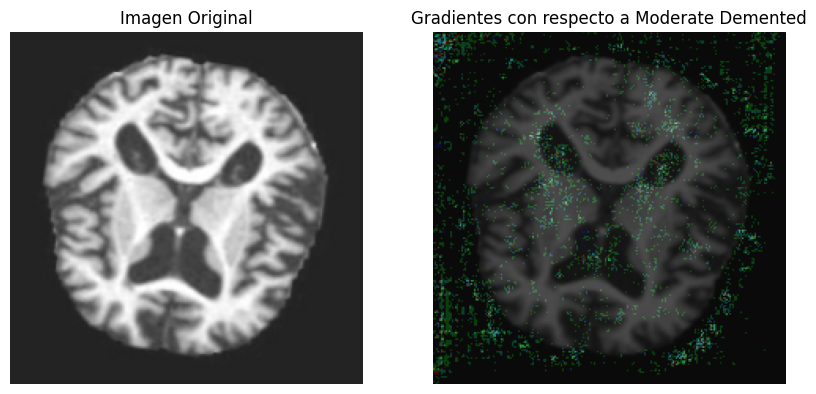

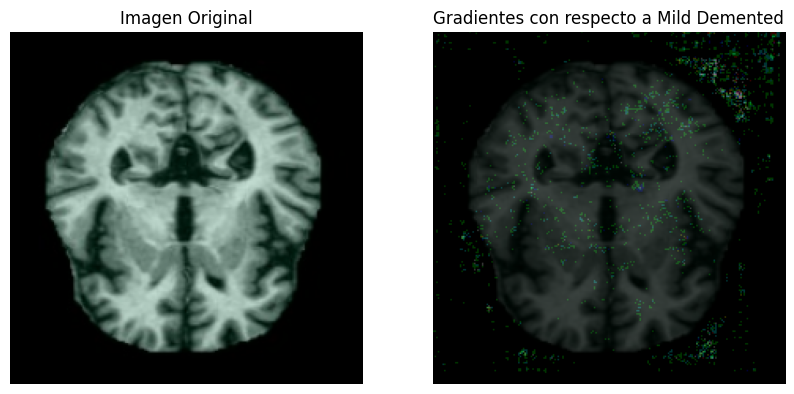

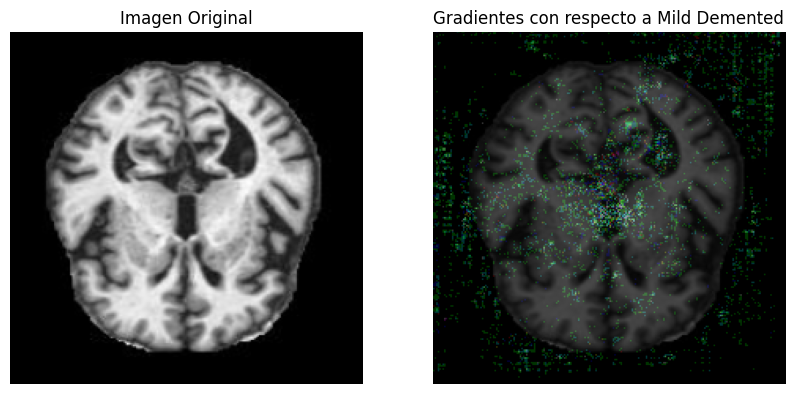

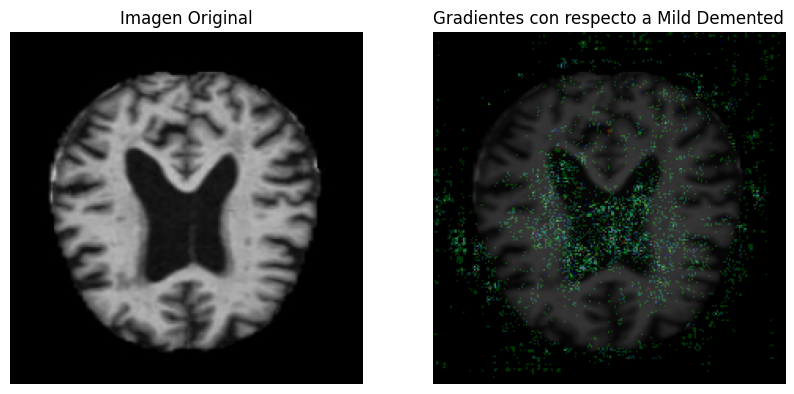

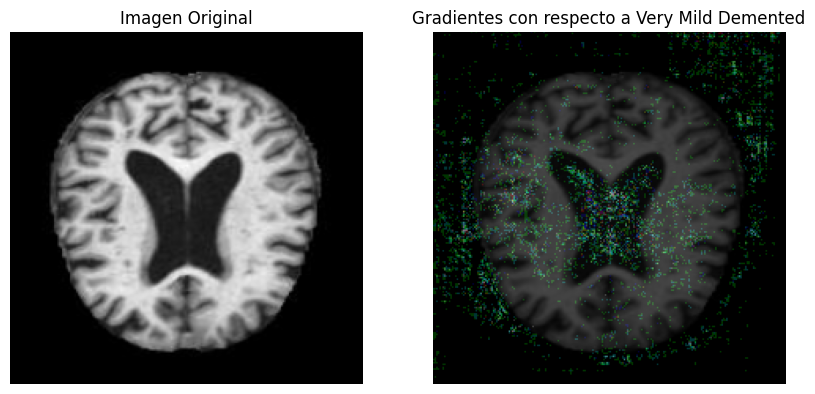

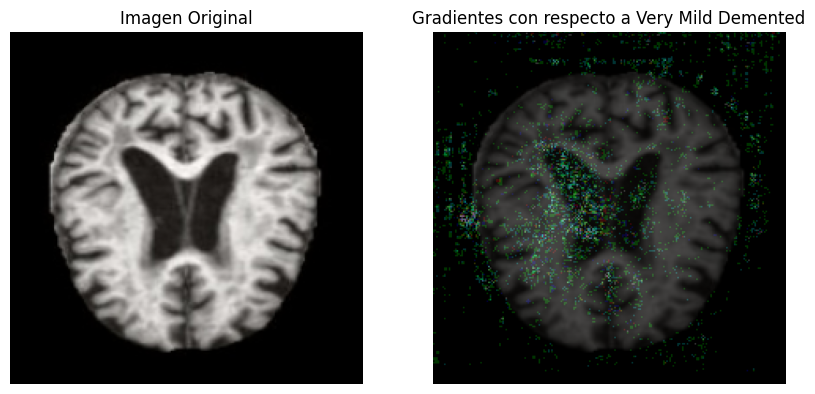

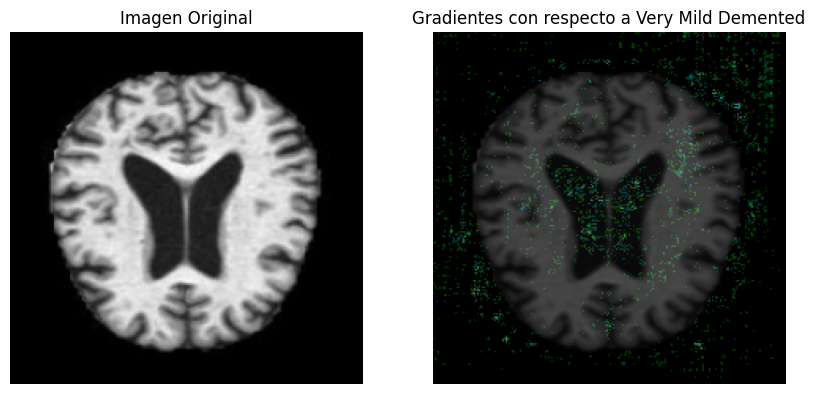

In [31]:
for i in imagenes_analizar:
    visualizar_gradientes(model, test_images[i], predictions[i])

# **Resnet 50 - 70%**

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Resizing
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout

# Suponiendo que tienes tus datos de imágenes cargados en X_train, X_test (208x176x3) y las etiquetas en y_train, y_test

# Define el número de clases
num_classes = 4

# Cargar el modelo ResNet50 pre-entrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(None, None, 3))  # Input shape no especificado

# Congelar las capas base para que no se vuelvan a entrenar
base_model.trainable = False

# Agregar capas adicionales para adaptar el modelo a tu problema de clasificación
model = Sequential([
    Resizing(224, 224),  # Redimensiona las imágenes a 224x224, el tamaño de entrada estándar de ResNet50
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax') # 4 clases de salida
])

# Compilar el modelo especificando la función de pérdida, el optimizador y las métricas
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo con tus datos de entrenamiento
model.fit(train_images, train_labels, epochs=5, batch_size=64, validation_data=(test_images, test_labels), class_weight=class_weights_dict)